# SARIMAX
adapted from (https://www.kaggle.com/code/sajikim/time-series-forecasting-methods-example-python/notebook)

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm

import pandas as pd
import warnings
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)

warnings.simplefilter('ignore')

In [2]:
combined_states = pd.read_csv(f'../data/combined_states.csv', parse_dates=['week'], index_col='week')
combined_states_covid_2020 = combined_states.loc[:'10-2020']
combined_states_covid_2020.tail()

,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
week,,,,,,,,,,
2020-09-27,50.7,72.9,18.8,32.7,40.0,0.1,0.6,0.5,0.5,0.5
2020-10-04,52.9,68.4,20.2,31.7,51.5,0.1,0.6,0.5,0.5,0.5
2020-10-11,53.1,69.8,18.6,30.4,40.4,0.1,0.6,0.5,0.5,0.5
2020-10-18,52.2,70.3,21.9,32.7,36.3,0.1,0.6,0.5,0.5,0.5
2020-10-25,48.7,70.3,17.5,28.9,35.7,0.1,0.6,0.5,0.5,0.5


In [25]:
# adapted from https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations 
        pdqs : seasonal ARIMA combinations 
        maxiter : number of iterations 
        
    Return:
        Returns dataframe of best five parameter combinations ranked by BIC
    '''
    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, 
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq='W-SUN')

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
            except:
                continue
            
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [23]:
def SARIMAX_model(train,test):
    # fit model
    model = SARIMAX(train.drop('depression', axis=1), exog=train['mask_mandate'], order=(1, 1, 2), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + len(test) - 1, exog=test["mask_mandate"].values)
    res=pd.DataFrame({"Pred":yhat, "depression":test["depression"].values,"mask_mandate":test["mask_mandate"].values})
    return res

In [24]:
def SARIMA_model(train,test):
    # fit model
    model = SARIMAX(train['depression'], order=(1, 1, 2), seasonal_order=(1,1,1,40))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + len(test) - 1)
    res=pd.DataFrame({"Pred":yhat, "depression":test["depression"].values})
    return res

## Grid Search best parameters for SARIMAX model

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 4 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    
### Apply function to your time series data ###
sarimax_gridsearch(df_train, pdq, pdqs)

## SARIMAX with Exogenous feature

In [13]:
df_train_ex = combined_states_covid_2020[['depression', 'mask_mandate']][:-15]
df_test_ex = combined_states_covid_2020[['depression', 'mask_mandate']][-15:]

In [14]:
df_ret_ex = SARIMAX_model(df_train_ex, df_test_ex)

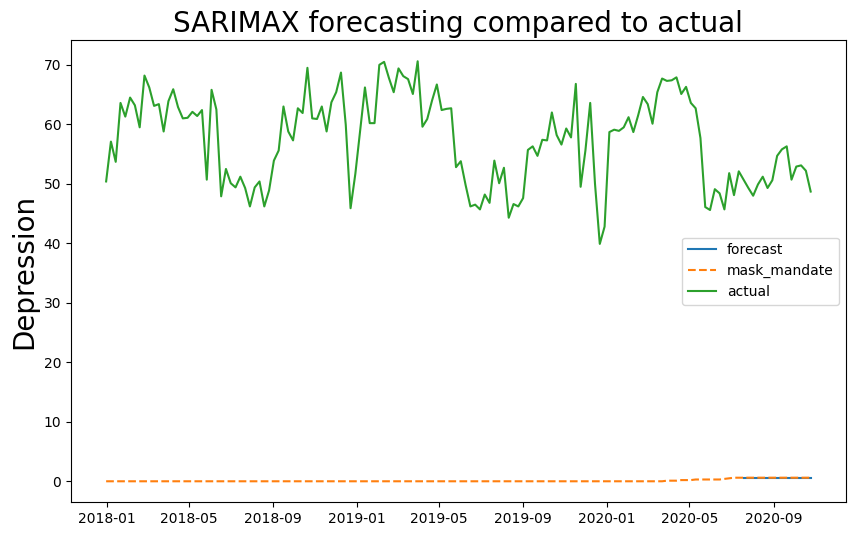

In [15]:
plt.figure(figsize = (10, 6))
plt.plot(df_ret_ex['Pred'], label = 'forecast')
plt.plot(combined_states_covid_2020['mask_mandate'], label = 'mask_mandate', linestyle = '--')
plt.plot(combined_states_covid_2020.index, combined_states_covid_2020['depression'], label = 'actual')
plt.legend()
plt.title('SARIMAX forecasting compared to actual', size=20)
plt.ylabel('Depression', size=20);

The model gave to much value to exogenous feature and does not give good predictions with. I will try to remove exogenous and fit the model again.

## SARIMA without Exogenous feature

In [16]:
df_train = combined_states_covid_2020[['depression']][:-15]
df_test = combined_states_covid_2020[['depression']][-15:]

In [17]:
df_ret = SARIMA_model(df_train, df_test)

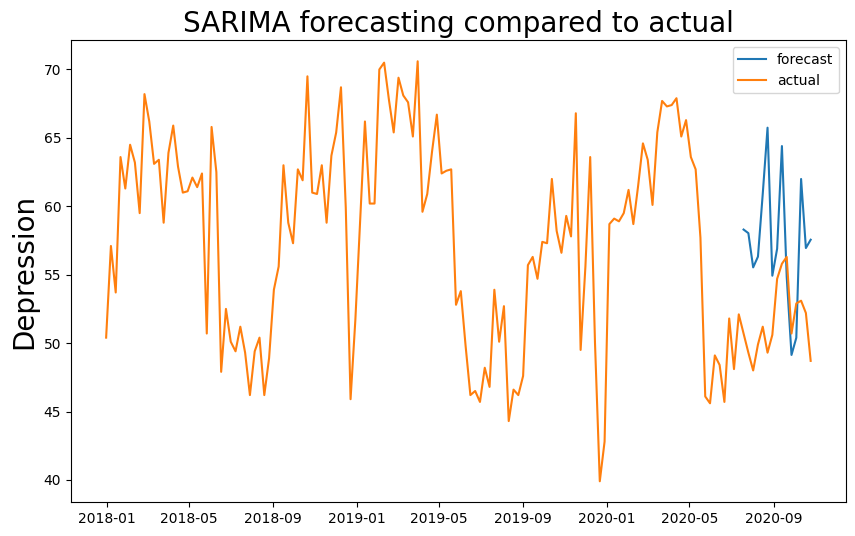

In [18]:
plt.figure(figsize = (10, 6))
plt.plot(df_ret['Pred'], label = 'forecast')
plt.plot(combined_states_covid_2020.index, combined_states_covid_2020['depression'], label = 'actual')
plt.legend()
plt.title('SARIMA forecasting compared to actual', size=20)
plt.ylabel('Depression', size=20);

SARIMA does not give good predictions on this data. I will try different forecasting model